<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/AI_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AI HW#5-2

In [1]:
# sklearn 라이브러리에서 fetch_openml 함수를 이용하여 MNIST 데이터셋 로드
from sklearn.datasets import fetch_openml

# 'mnist_784' 데이터셋을 로드. 데이터셋의 버전은 version=1, 로드된 데이터를 캐시에 저장하여 재사용이 용이하게 함.
mnist = fetch_openml('mnist_784', version=1, cache=True)
# 데이터셋에서 특성(이미지 픽셀 값)을 X에 할당.  255로 나누어 정규화를 수행
X = mnist.data / 255.0
# 데이터셋에서 타겟(숫자 레이블)을 y에 할당
y = mnist.target

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


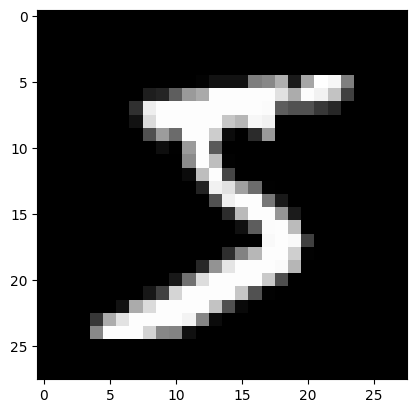

이미지 레이블 : 5


In [2]:
# 데이터를 시각화하는 데 사용
import matplotlib.pyplot as plt

# MNIST 데이터셋의 첫 번째 이미지를 표시.
# X.iloc[0].values.reshape(28, 28) : 첫 번째 이미지 데이터를 28x28 픽셀 크기로 재배열.
# cmap='gray' : 이미지를 회색조로 표시하도록 지정.
plt.imshow(X.iloc[0].values.reshape(28, 28), cmap='gray')
# 이미지 화면에 출력
plt.show()
# 첫번째 이미지의 레이블 출력.
print('이미지 레이블 : {}'.format(y[0]))

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 데이터셋을 학습용 데이터와 테스트용 데이터로 분할
# test_size=1/7. : 전체 데이터셋의 약 1/7을 테스트 데이터로 사용
# random_state=0 : 데이터 분할시 무작위성을 제어하기 위한 값
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7., random_state=0)

# DataFrame을 NumPy 배열로 변환한 후 PyTorch Tensor로 변환
X_train = torch.Tensor(X_train.values)
X_test = torch.Tensor(X_test.values)

# 레이블 데이터(y)를 정수로 변환하고 PyTorch Tensor로 변환
y_train = torch.LongTensor(list(map(int,y_train)))
y_test = torch.LongTensor(list(map(int,y_test)))

# 학습 데이터셋과 테스트 데이터셋을 PyTorch의 TensorDataset으로 변환
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader를 사용하여 배치 크기를 지정.
# 학습 데이터는 셔플, 테스트 데이터는 셔플X
# 이를 통해 모델 학습 시 미니배치 학습을 수행할 수 있음
loader_train = DataLoader(ds_train, batch_size = 64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size = 64, shuffle=False)

In [4]:
# MLP 모델 제작
from torch import nn

# nn.Sequential을 사용하여 신경망 레이어들을 순차적으로 정의
model = nn.Sequential()

# 첫 번째 선형 레이어(fc1)를 추가
# 이 레이어는 입력 노드 784개(28*28 픽셀)와 출력 노드 100개를 가짐
model.add_module('fc1', nn.Linear(28*28*1, 100))

# 첫 번째 ReLU 활성화 함수(relu1)를 추가
# ReLU는 비선형성을 도입하여 모델이 복잡한 패턴을 학습할 수 있게 도움
model.add_module('relu1', nn.ReLU())

# 두 번째 선형 레이어(fc2)를 추가
# 이 레이어는 입력 노드 100개와 출력 노드 100개를 가짐
model.add_module('fc2', nn.Linear(100, 100))

# 두 번째 ReLU 활성화 함수(relu2)를 추가
model.add_module('relu2', nn.ReLU())

# 세 번째 선형 레이어(fc3)를 추가
# 이 레이어는 입력 노드 100개와 출력 노드 10개를 가짐
# 출력 노드의 수는 MNIST 데이터셋의 클래스 수(0-9)와 일치
model.add_module('fc3', nn.Linear(100, 10))

In [5]:
from torch import optim

# 교차 엔트로피 손실 함수를 정의
loss_fn = nn.CrossEntropyLoss()

# Adam 최적화 알고리즘을 사용
# model.parameters()는 모델의 모든 학습 가능한 매개변수를 가져옴
# lr=0.01은 학습률(learning rate)을 0.01로 설정함.
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [7]:
# train 함수는 주어진 epoch에 대해 모델 학습을 수행
def train(epoch):
    # 모델을 학습 모드로 설정합니다.
    model.train()

    # 학습 데이터 로더를 순회
    for data, targets in loader_train:
        # 모든 최적화된 변수의 그라디언트를 0으로 설정
        # 이는 새로운 최적화 단계를 시작하기 전에 이전 단계의 그라디언트를 지우기 위함
        optimizer.zero_grad()

        # 모델에 데이터를 전달하여 예측을 수행
        outputs = model(data)

        # 예측 결과와 실제 타겟 값을 비교하여 손실을 계산
        loss = loss_fn(outputs, targets)

        # 손실에 대한 그라디언트를 역전파합니다. 이는 모델의 매개변수를 최적화하기 위해 필요
        loss.backward()

        # 최적화 알고리즘을 한 단계 실행합니다. 이는 모델의 가중치를 업데이트
        optimizer.step()

    # 현재 epoch의 학습이 완료되었음을 출력
    print('epoch {}: 완료'.format(epoch))

In [8]:
def test(head):
    # 모델을 평가(evaluation) 모드로 설정
    # 이는 모든 학습 관련 연산을 비활성화(예: 드롭아웃).
    model.eval()

    # 정확하게 예측된 샘플의 수를 저장하기 위한 변수
    correct = 0

    # 그라디언트 계산을 비활성화
    with torch.no_grad():
        # 테스트 데이터 로더를 순회
        for data, targets in loader_test:
            # 모델에 데이터를 전달하여 예측을 수행
            outputs = model(data)

            # 가장 높은 값(최종 예측)을 가진 인덱스를 가져옴
            _, predicted = torch.max(outputs.data, 1)

            # 정확한 예측의 수를 누적
            correct += predicted.eq(targets.data.view_as(predicted)).sum()

    # 테스트 데이터셋의 전체 데이터 수를 가져옴
    data_num = len(loader_test.dataset)

    # 정확도를 계산하고 출력
    print('accuracy = ', 100. * correct / data_num)

In [9]:
# epoch(반복횟수) 3
for epoch in range(3):
  train(epoch)
  test('학습중')

epoch 0: 완료
accuracy =  tensor(95.2400)
epoch 1: 완료
accuracy =  tensor(95.4600)
epoch 2: 완료
accuracy =  tensor(95.1700)


In [8]:
# AI HW5-3

In [1]:
# sklearn 라이브러리에서 fetch_openml 함수를 이용하여 MNIST 데이터셋 로드
from sklearn.datasets import fetch_openml

# 'mnist_784' 데이터셋을 로드. 데이터셋의 버전은 version=1, 로드된 데이터를 캐시에 저장하여 재사용이 용이하게 함.
mnist = fetch_openml('mnist_784', version=1, cache=True)
# 데이터셋에서 특성(이미지 픽셀 값)을 X에 할당.
X = mnist.data
# 데이터셋에서 타겟(숫자 레이블)을 y에 할당
y = mnist.target

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 데이터셋을 학습용 데이터와 테스트용 데이터로 분할
# test_size=1/7. : 전체 데이터셋의 약 1/7을 테스트 데이터로 사용
# random_state=0 : 데이터 분할시 무작위성을 제어하기 위한 값
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7., random_state=0)

# DataFrame을 NumPy 배열로 변환한 후 PyTorch Tensor로 변환
X_train = torch.Tensor(X_train.values)
X_test = torch.Tensor(X_test.values)

# 레이블 데이터(y)를 정수로 변환하고 PyTorch Tensor로 변환
y_train = torch.LongTensor(list(map(int,y_train)))
y_test = torch.LongTensor(list(map(int,y_test)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

# X_train과 X_test 텐서의 모양을 CNN 모델에 적합하게 변경
# -1은 배치 크기를 나타내며, PyTorch가 자동으로 이 값을 계산
# 1은 채널의 수를 나타내며, MNIST 데이터셋은 그레이스케일 이미지이므로 채널이 하나
# 28, 28은 이미지의 높이와 너비
X_train = X_train.view(-1,1,28,28).float()
X_test = X_test.view(-1,1,28,28).float()

# 텐서 모양 출력
print(X_train.shape)
print(X_test.shape)

# 학습 데이터셋과 테스트 데이터셋을 PyTorch의 TensorDataset으로 변환
train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)

BATCH_SIZE = 32
# DataLoader를 사용하여 배치 크기를 지정.
# 학습 데이터는 셔플, 테스트 데이터는 셔플X
# 이를 통해 모델 학습 시 미니배치 학습을 수행할 수 있음
loader_train = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True)
loader_test = DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [4]:
# CNN 모델 클래스 정의. nn.Module을 상속받아 PyTorch 모델을 구현
class CNN(nn.Module):
    def __init__(self):
        # 부모 클래스의 생성자를 호출
        super(CNN, self).__init__()
        # 첫 번째 컨볼루션 레이어: 1개의 입력 채널(그레이스케일 이미지), 32개의 출력 채널, 5x5 커널
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # 두 번째 컨볼루션 레이어: 32개의 입력 채널, 32개의 출력 채널, 5x5 커널
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        # 세 번째 컨볼루션 레이어: 32개의 입력 채널, 64개의 출력 채널, 5x5 커널
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        # 첫 번째 완전 연결 레이어: 입력 특성 576개(3x3x64), 출력 특성 256개
        self.fc1 = nn.Linear(3*3*64, 256)
        # 두 번째 완전 연결 레이어: 입력 특성 256개, 출력 특성 10개 (10개의 클래스)
        self.fc2 = nn.Linear(256, 10)
        # 손실 함수 및 최적화기 정의
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.01)

    def forward(self, x):
        # 첫 번째 컨볼루션 레이어 + ReLU 활성화 함수
        x = F.relu(self.conv1(x))
        # 두 번째 컨볼루션 레이어 + 맥스풀링 + ReLU 활성화 함수
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # 드롭아웃 적용
        x = F.dropout(x, p=0.5, training=self.training)
        # 세 번째 컨볼루션 레이어 + 맥스풀링 + ReLU 활성화 함수
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        # 드롭아웃 적용
        x = F.dropout(x, p=0.5, training=self.training)
        # 평탄화(Flatten) - 완전 연결 레이어에 입력하기 전에 형태 변환
        x = x.view(-1, 3*3*64)
        # 첫 번째 완전 연결 레이어 + ReLU 활성화 함수
        x = F.relu(self.fc1(x))
        # 드롭아웃 적용
        x = F.dropout(x, training=self.training)
        # 두 번째 완전 연결 레이어
        x = self.fc2(x)
        # 로그-소프트맥스 함수를 사용하여 출력을 확률 분포로 변환
        return F.log_softmax(x, dim=1)

In [5]:
# fit 함수는 모델과 학습 데이터 로더를 인자로 받아 모델을 학습시킴
def fit(model, loader_train):
    # 모델의 매개변수에 대해 Adam 최적화기를 설정
    optimizer = torch.optim.Adam(model.parameters())
    # 교차 엔트로피 손실 함수를 설정
    error = nn.CrossEntropyLoss()
    # 학습할 에포크 수를 설정
    EPOCHS = 1
    # 모델을 학습 모드로 설정
    model.train()
    # 에포크 수만큼 반복
    for epoch in range(EPOCHS):
        # 정확히 예측된 샘플의 수를 저장할 변수
        correct = 0
        # 배치 단위로 학습 데이터를 순회
        for batch_idx, (X_batch, y_batch) in enumerate(loader_train):
            # 배치 데이터를 PyTorch Variable로 변환
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            # 이전 그라디언트를 초기화
            optimizer.zero_grad()
            # 모델에 배치 데이터를 전달하여 출력을 계산
            output = model(var_X_batch)
            # 출력과 실제 타겟 사이의 손실을 계
            loss = error(output, var_y_batch)
            # 손실에 대한 그라디언트를 역전파
            loss.backward()
            # 최적화기를 사용하여 모델의 가중치를 업데이트
            optimizer.step()
            # 예측 결과를 계산
            predicted = torch.max(output.data, 1)[1]
            # 정확한 예측 수를 업데이트
            correct += (predicted == var_y_batch).sum()
            # 일정한 간격으로 학습 진행 상황을 출력
            if batch_idx % 50 == 0:
                print('에포크 : {} [{}/{}({:.0f}%)]\t 손실함수 : {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx, len(loader_train),
                    100. * batch_idx / len(loader_train), loss.data,
                    correct * 100. / (BATCH_SIZE * (batch_idx + 1))))

In [6]:
# evaluate 함수는 모델을 인자로 받아 테스트 데이터셋에 대해 평가 진행
def evaluate(model):
    # 정확하게 예측된 샘플의 수를 저장하기 위한 변수
    correct = 0
    # 테스트 데이터셋을 순회
    for test_imgs, test_labels in loader_test:
        # 테스트 이미지들을 PyTorch Variable로 변환
        test_imgs = Variable(test_imgs).float()
        # 모델에 테스트 이미지를 전달하여 예측을 수행
        output = model(test_imgs)
        # 가장 높은 값(최종 예측)을 가진 인덱스를 가져옴
        predicted = torch.max(output, 1)[1]
        # 정확한 예측의 수를 누적
        correct += (predicted == test_labels).sum()
    # 전체 테스트 데이터셋에 대한 정확도를 계산하고 출력
    print("테스트 데이터 정확도 : {:.3f}%".format(float(correct) / (len(loader_test) * BATCH_SIZE)))

In [7]:
# CNN 모델 인스턴스를 생성
cnn = CNN()
# 모델의 초기 성능을 평가(모델은 아직 학습되지 않음)
evaluate(cnn)
# 모델을 학습 데이터셋을 사용하여 학습
fit(cnn, loader_train)
# 모델을 평가 모드로 설정합니다. 이는 학습에 사용되는 특정 동작들(예: 드롭아웃)을 비활성화
cnn.eval()
# 학습된 모델의 성능을 다시 평가
evaluate(cnn)
# 테스트 데이터셋의 특정 샘플에 대한 모델의 예측을 수행
index = 10
data = X_test[index].view(-1, 1, 28, 28).float()
output = cnn(data)
# 해당 샘플에 대한 모델의 예측 결과를 출력
print('{}번째 학습데이터의 테스트 결과 : {}'.format(index, output))
# 모델이 가장 높은 확률을 가진 클래스를 예측값으로 선택
_, predicted = torch.max(output, 1)
# 예측된 클래스를 출력
print("{}번째 데이터의 예측 : {}".format(index, predicted.numpy()))
# 실제 레이블을 출력
print("실제 레이블 : {}".format(y_test[index]))

테스트 데이터 정확도 : 0.100%
에포크 : 0 [0/1875(0%)]	 손실함수 : 20.982010	 Accuracy:6.250%
에포크 : 0 [50/1875(3%)]	 손실함수 : 2.048203	 Accuracy:18.873%
에포크 : 0 [100/1875(5%)]	 손실함수 : 0.890816	 Accuracy:33.014%
에포크 : 0 [150/1875(8%)]	 손실함수 : 0.603484	 Accuracy:43.936%
에포크 : 0 [200/1875(11%)]	 손실함수 : 0.969049	 Accuracy:52.410%
에포크 : 0 [250/1875(13%)]	 손실함수 : 0.478824	 Accuracy:58.230%
에포크 : 0 [300/1875(16%)]	 손실함수 : 0.428750	 Accuracy:62.915%
에포크 : 0 [350/1875(19%)]	 손실함수 : 0.727131	 Accuracy:66.382%
에포크 : 0 [400/1875(21%)]	 손실함수 : 0.379134	 Accuracy:69.132%
에포크 : 0 [450/1875(24%)]	 손실함수 : 0.328618	 Accuracy:71.307%
에포크 : 0 [500/1875(27%)]	 손실함수 : 0.396366	 Accuracy:73.085%
에포크 : 0 [550/1875(29%)]	 손실함수 : 0.306091	 Accuracy:74.705%
에포크 : 0 [600/1875(32%)]	 손실함수 : 0.231129	 Accuracy:76.045%
에포크 : 0 [650/1875(35%)]	 손실함수 : 0.202085	 Accuracy:77.285%
에포크 : 0 [700/1875(37%)]	 손실함수 : 0.190990	 Accuracy:78.290%
에포크 : 0 [750/1875(40%)]	 손실함수 : 0.115450	 Accuracy:79.203%
에포크 : 0 [800/1875(43%)]	 손실함수 : 0.268436	 